In [1]:
%reload_ext autoreload
%autoreload 2

In [16]:
import os
import json
import matplotlib.pyplot as plt
import scipy
import pandas as pd
import seaborn as sns
import shutil
from PIL import Image
from sklearn.model_selection import train_test_split

from k12libs.utils.nb_easy import K12AI_DATASETS_ROOT
from k12libs.utils.nb_dataset import k12ai_compute_mean_std

## 精简

In [3]:
data_root = os.path.join(K12AI_DATASETS_ROOT, 'cv', 'rDogsVsCats')
train_val_json = os.path.join(K12AI_DATASETS_ROOT, 'cv', 'dogsVsCats', 'train_val.json')
items = []
with open(train_val_json, 'r') as f:
    items = json.load(f)
len(items)

18000

### 读取

In [4]:
train_val_df = pd.read_json(train_val_json, encoding="utf-8", orient='records')
train_val_df[:5]

,image_path,label
0,imgs/train/dog.2983.jpg,0
1,imgs/train/dog.10127.jpg,0
2,imgs/train/cat.7282.jpg,1
3,imgs/train/cat.10214.jpg,1
4,imgs/train/dog.9504.jpg,0


### 查看是否均匀分布

In [5]:
grouped_by_label = train_val_df.groupby('label')
grouped_by_label.count()

,image_path
label,
0,9058
1,8942


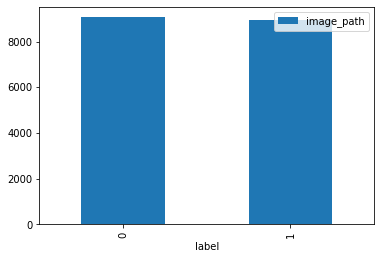

In [6]:
grouped_by_label.count().plot(kind='bar');

### 随机精简

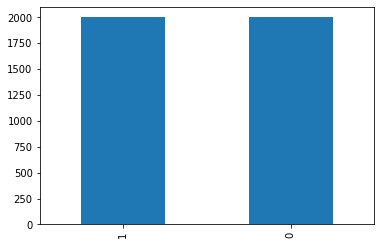

In [7]:
# 合理: 先分组, 然后组中随机样本
reduced_df = train_val_df.groupby('label').apply(pd.DataFrame.sample, n=2000, random_state=20, replace=False)
reduced_df['label'].value_counts().plot(kind='bar');

### 对样本随机打散

In [8]:
reduced_shuffle_df = reduced_df.sample(frac=1)
reduced_shuffle_df[15:25]

image_path  label
label                                       
1     4355    imgs/train/cat.6249.jpg      1
0     1291    imgs/train/dog.1453.jpg      0
      6212   imgs/train/dog.10828.jpg      0
      7029    imgs/train/dog.8964.jpg      0
1     5118    imgs/train/cat.1421.jpg      1
      2990    imgs/train/cat.5644.jpg      1
0     12510   imgs/train/dog.5184.jpg      0
      2246    imgs/train/dog.6597.jpg      0
      13644   imgs/train/dog.8445.jpg      0
      13445   imgs/train/dog.8245.jpg      0

### 分割数据集6:2:2

In [9]:
train_valid_df, test_df = train_test_split(reduced_shuffle_df, test_size=0.2)
train_df, valid_df = train_test_split(train_valid_df, test_size=0.2)
len(train_df), len(valid_df), len(test_df), len(reduced_shuffle_df)

(2560, 640, 800, 4000)

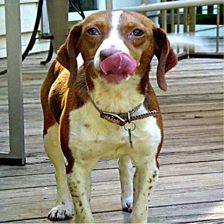

In [10]:
image_path = test_df[0:10]['image_path'].tolist()[0]
image_path = os.path.join(K12AI_DATASETS_ROOT, 'cv', 'dogsVsCats', image_path)
Image.open(image_path).resize((224, 224))

## 保存精简数据集rDogsVsCats

In [11]:
def generate_json_file(df, phase):
    src_root = os.path.join(K12AI_DATASETS_ROOT, 'cv', 'dogsVsCats')
    dst_root = os.path.join(K12AI_DATASETS_ROOT, 'cv', 'rDogsVsCats')
    
    img_path = os.path.join(dst_root, 'imgs', phase)
    shutil.rmtree(img_path, ignore_errors=True)
    os.makedirs(img_path)
    
    results = []
    items = df.to_dict(orient='records')
    print(f'{phase} count: {len(items)}')
    for item in items:
        filename = os.path.basename(item['image_path'])
        src_path = os.path.join(src_root, item['image_path'])
        dst_path = os.path.join(img_path, filename)
        if not os.path.exists(src_path):
            print('not found:', src_path)
        if os.path.exists(dst_path):
            print('replce found:', dst_path)
        results.append({
            'image_path': f'imgs/{phase}/{filename}',
            'label': item['label']
        })
        Image.open(src_path).resize((256, 256)).crop((16, 16, 240, 240)).save(dst_path)
        # shutil.copy2(src_path, dst_path)
        
    with open(os.path.join(dst_root, f'{phase}.json'), 'w') as f:
        json.dump(results, f)
    return len(results)
        
test_count = generate_json_file(test_df, 'test')
train_count = generate_json_file(train_df, 'train')
val_count = generate_json_file(valid_df, 'val')

test count: 800
train count: 2560
val count: 640


### 生成info.json

In [13]:
jfiles = ['train.json', 'val.json', 'test.json']
mean, std = k12ai_compute_mean_std(datadir=data_root, jfiles=jfiles)

In [18]:
info = {
    'num_records': train_count + val_count + test_count,
    'num_classes': 2,
    'label_names': ['dog', 'cat'],
    'mean': mean,
    'std': std,
}

with open(os.path.join(data_root, 'info.json'), 'w') as fw:
    json.dump(info, fw, indent=4)
    
info

{'num_records': 4000,
 'num_classes': 2,
 'label_names': ['dog', 'cat'],
 'mean': [0.4861, 0.4499, 0.4115],
 'std': [0.2251, 0.2206, 0.2198]}

<Figure size 432x288 with 0 Axes>

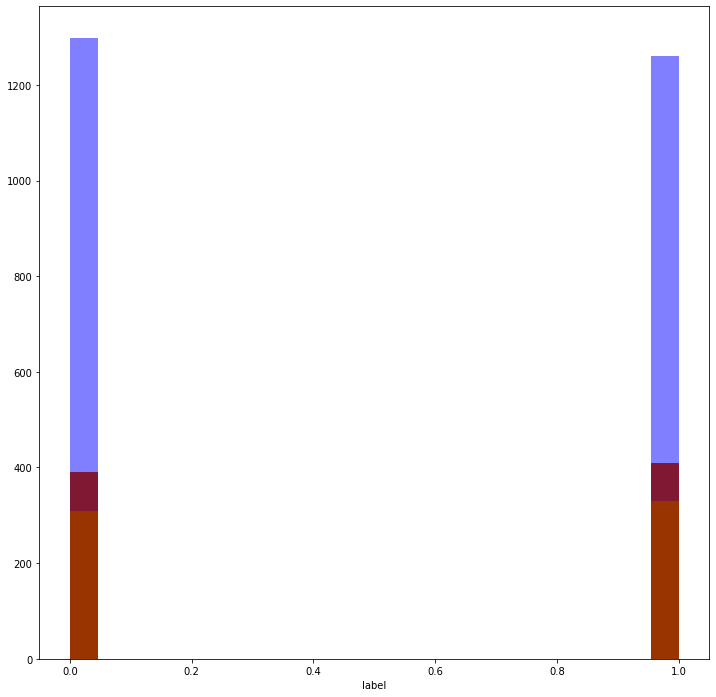

In [17]:
def draw_hist():
    plt.clf()
    fig = plt.figure(figsize=(12, 12))
    train_file = os.path.join(data_root, 'train.json')
    val_file = os.path.join(data_root, 'val.json')
    test_file = os.path.join(data_root, 'test.json')
    df_train = pd.read_json(train_file)
    df_val = pd.read_json(val_file)
    df_test = pd.read_json(test_file)
    for df, co, alpha in ((df_train, 'blue', 0.5), (df_val, 'yellow', 1), (df_test, 'maroon', 0.8)):
        sns.distplot(df['label'],
                 # fit=scipy.stats.norm,
                 kde=False,
                 hist=True,
                 hist_kws={"linewidth": 2, "alpha": alpha, 'color': co},
                 # rug=True,
                 bins=22)
    plt.savefig(f'{data_root}/labels_hist.png')
    plt.show()
draw_hist()